In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx
import scipy.optimize
from scipy.optimize import curve_fit


In [2]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 800
N_CHART = 800

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 30

# Maximum extension for chartists' timesteps window 
T_MAX = 15

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

# Information Threshold
Ith = 1

In [3]:
class Agent:
    """
    Agent class represents an agent in the market.
    """
    def __init__(self, type, wealth, money, quantity, expected_price, decision, info):
        """
        Initialize an agent with the given parameters.

        Parameters:
        type (str): The type of the agent, either 'fund' or 'chart'.
        wealth (float): The wealth of the agent.
        money (float): The money the agent has.
        quantity (float): The quantity of the product the agent has.
        expected_price (float): The price the agent expects.
        decision (str): The decision of the agent, either 'buy', 'sell', or 'hold'.
        info (float): The information the agent has.
        """
        self.type = type
        self.wealth = wealth
        self.money = money
        self.quantity = quantity
        self.expected_price = expected_price
        self.decision = decision
        self.info = info

class Market:
    """
    Market class represents a market with multiple agents.
    """
    def __init__(self, N, W, M, Q, Ith, ALPHA, TAO, actual_price, num_iterations, avg_degree, reconnection_prob, price_range):
        """
        Initialize a market with the given parameters.

        Parameters:
        N (int): The number of agents in the market.
        W (list): The wealth of each agent.
        M (float): The money each agent has.
        Q (float): The quantity of the product each agent has.
        Ith (float): The information threshold.
        ALPHA (float): The information dissemination factor.
        TAO (float): The price threshold.
        actual_price (float): The actual price of the product.
        num_iterations (int): The number of iterations for the simulation.
        avg_degree (int): The average degree for the Watts-Strogatz graph.
        reconnection_prob (float): The reconnection probability for the Watts-Strogatz graph.
        price_range (tuple): The range of prices for the agents.
        """
        self.network = nx.watts_strogatz_graph(N, avg_degree, reconnection_prob)
        self.agents = [Agent(np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=price_range[0], high=price_range[1]), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith)) for i in range(N)]
        self.state_counts = {'buy': [], 'sell': [], 'hold': []}
        self.info_counts = []
        self.actual_price = actual_price
        self.ALPHA = ALPHA
        self.Ith = Ith
        self.TAO = TAO
        self.num_iterations = num_iterations
        self.price_range = price_range

    def propagate_info(self, agent_index):
        """
        Propagate the information of an agent to its neighbors in the network.

        Parameters:
        agent_index (int): The index of the agent in the agents list.
        """
        agent = self.agents[agent_index]
        neighbors = list(self.network.neighbors(agent_index))
        if agent.info >= self.Ith:
            self.info_counts[-1] += 1
            store_info = agent.info
            agent.info = 0
            for neighbor in neighbors:
                self.agents[neighbor].info += (self.ALPHA / len(neighbors)) * store_info
                self.agents[neighbor].info = min(self.agents[neighbor].info, np.finfo(float).max)
                if self.agents[neighbor].info >= self.Ith:
                    self.agents[neighbor].decision = agent.decision
                    self.propagate_info(neighbor)  # Recursive call
                    
    def simulate_market_dynamics(self):
        """
        Simulate the market dynamics by iterating over the agents and updating their states.
        """
        for t in range(1, self.num_iterations):
            info_count = 0
            self.info_counts.append(info_count)
            copy_agents = self.agents.copy()
            for agent in self.agents:
                agent.info += np.random.uniform(0, (self.Ith - max([a.info for a in copy_agents])))
                agent.expected_price = np.random.uniform(low=self.price_range[0], high=self.price_range[1])

            for agent in self.agents:
                if agent.type == 'fund':
                    price_difference = agent.expected_price - self.actual_price
                    if abs(price_difference) < self.TAO:
                        agent.decision = 'hold'
                    elif price_difference > self.TAO and agent.money > 0:
                        agent.decision = 'buy'
                    elif price_difference < -self.TAO and agent.quantity > 0:
                        agent.decision = 'sell'

            for i, agent in enumerate(self.agents):
                self.propagate_info(i)

            current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
            for agent in self.agents:
                current_state_counts[agent.decision] += 1
            for state in self.state_counts:
                self.state_counts[state].append(current_state_counts[state])


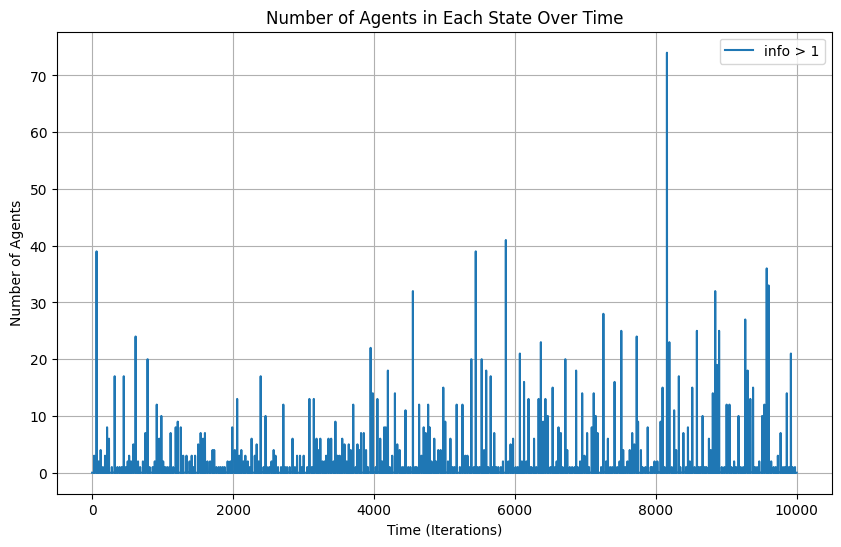

In [4]:
# Main code

actual_price = 100  # Initial actual price
num_iterations = 10000  # Number of iterations for the simulation
avg_degree = 4  # Average degree for the Watts-Strogatz graph
reconnection_prob = 0.02  # Reconnection probability for the Watts-Strogatz graph
price_range = (50, 150)  # Range of prices for the agents

market = Market(N, W, M, Q, Ith, ALPHA, TAO, actual_price, num_iterations, avg_degree, reconnection_prob, price_range)
market.simulate_market_dynamics()


# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
# for state, counts in state_counts.items():
#     plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(market.info_counts)), market.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

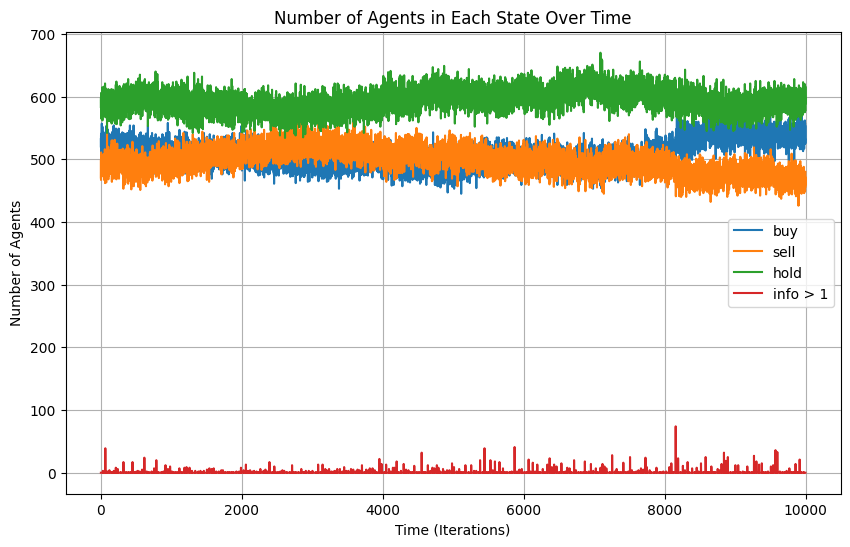

In [8]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in market.state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(market.info_counts)), market.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

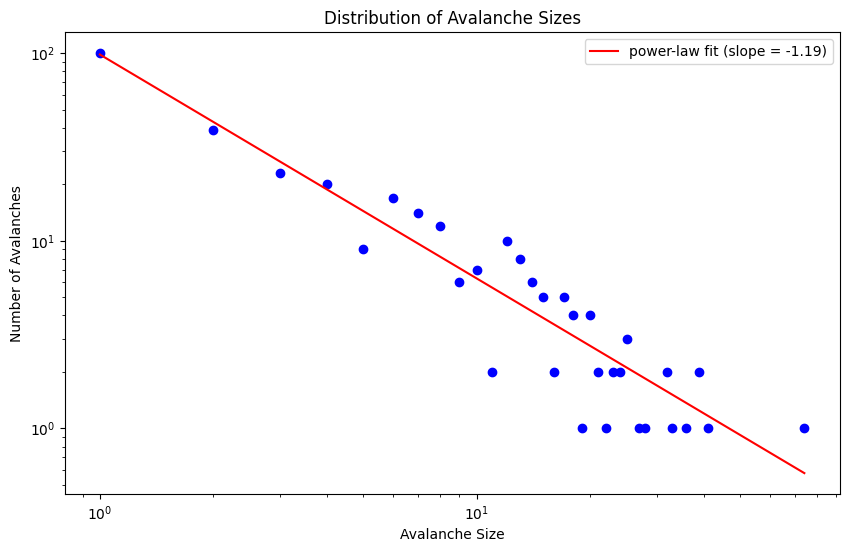

In [6]:
# Filter out the time steps where no avalanche occurred
avalanche_sizes = np.array(market.info_counts)
avalanche_sizes = avalanche_sizes[avalanche_sizes > 0]

# Calculate the unique avalanche sizes and their counts
avalanche_sizes, counts = np.unique(avalanche_sizes, return_counts=True)

# Define the power-law function for fitting
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit the power-law curve to the data
params, _ = curve_fit(power_law, avalanche_sizes, counts)

# Unpack fitting parameters for plotting
a, b = params

plt.figure(figsize=(10, 6))
plt.scatter(avalanche_sizes, counts, color='blue')  # Scatter plot of the raw data

# Generate points for the fitted line
fitted_line = power_law(avalanche_sizes, a, b)

# Plot the fitted line
plt.plot(avalanche_sizes, fitted_line, label=f'power-law fit (slope = {b:.2f})', color='red')

# Set the plot to log-log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Avalanche Size')
plt.ylabel('Number of Avalanches')
plt.title('Distribution of Avalanche Sizes')

plt.legend()
plt.show()